### Downloading the data

In [ ]:
!pip install kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tejaswini2091","key":"66cd9f45e2a185ad63565d1d29eea616"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 99% 800M/812M [00:03<00:00, 247MB/s]
100% 812M/812M [00:03<00:00, 213MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

#Transferring pictures to test, validation, and training folders and intially considering 1000 for train, 500 for test and 500 for validation

In [6]:
import os
import shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_small_1000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

# Define the ranges for each subset
subset_ranges = {
    "train": (0, 1000),
    "validation": (1000, 1500),
    "test": (1500, 2000)
}

# Generate the subsets
for subset_name, (start, end) in subset_ranges.items():
    make_subset(subset_name, start, end)


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input shape
input_shape = (180, 180, 3)
inputs = keras.Input(shape=input_shape)

# Data preprocessing: Rescale the input values to the range [0, 1]
x = layers.Rescaling(1./255)(inputs)

# Define the convolutional layers
conv_filters = [32, 64, 128, 256, 256]
for filters in conv_filters:
    x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

# Flatten the output for fully connected layers
x = layers.Flatten()(x)

# Define the output layer with sigmoid activation for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                     

**Configuring the model for training**

In [8]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

#Training = 1000; Validation = 500; Test = 500

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [10]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [11]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [12]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [13]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


#Displaying the shapes of the data and labels yielded by the Dataset

In [14]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


#Fitting the model using a Dataset

In [ ]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/20
63/63 [==============================] - 228s 4s/step - loss: 0.5823 - accuracy: 0.6905 - val_loss: 0.5999 - val_accuracy: 0.6730
Epoch 2/20
63/63 [==============================] - 194s 3s/step - loss: 0.5456 - accuracy: 0.7210 - val_loss: 0.6121 - val_accuracy: 0.6620
Epoch 3/20
63/63 [==============================] - 179s 3s/step - loss: 0.5022 - accuracy: 0.7550 - val_loss: 0.5442 - val_accuracy: 0.7240
Epoch 4/20
63/63 [==============================] - 196s 3s/step - loss: 0.4401 - accuracy: 0.7940 - val_loss: 0.5720 - val_accuracy: 0.7320
Epoch 5/20
63/63 [==============================] - 195s 3s/step - loss: 0.3959 - accuracy: 0.8205 - val_loss: 0.5867 - val_accuracy: 0.7400
Epoch 6/20
63/63 [==============================] - 192s 3s/step - loss: 0.3303 - accuracy: 0.8545 - val_loss: 0.5909 - val_accuracy: 0.7320
Epoch 7/20
63/63 [==============================] - 191s 3s/step - loss: 0.2382 - accuracy: 0.8950 - val_loss: 0.7806 - val_accuracy: 0.7240
Epoch 8/20
63

#Displaying curves of loss and accuracy during training

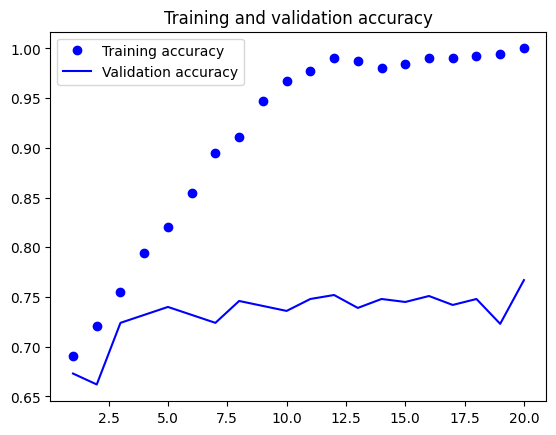

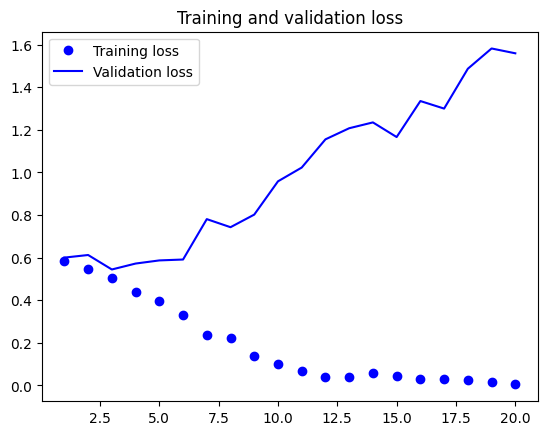

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#Evaluating the model on the test set

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 25s 738ms/step - loss: 0.5659 - accuracy: 0.6980
Test accuracy: 0.698


#Transferring pictures to test, validation, and training folders and intially considering 2000 for train, 500 for test and 500 for validation

In [ ]:
import os
import shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_small_2000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

# Define the ranges for each subset
subset_ranges = {
    "train": (0, 2000),
    "validation": (2000, 2500),
    "test": (2500, 3000)
}

# Generate the subsets
for subset_name, (start, end) in subset_ranges.items():
    make_subset(subset_name, start, end)


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input shape
input_shape = (180, 180, 3)
inputs = keras.Input(shape=input_shape)

# Data preprocessing: Rescale the input values to the range [0, 1]
x = layers.Rescaling(1./255)(inputs)

# Define the convolutional layers
conv_filters = [32, 64, 128, 256, 256]
for filters in conv_filters:
    x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

# Flatten the output for fully connected layers
x = layers.Flatten()(x)

# Define the output layer with sigmoid activation for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                     

**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

#Training = 2000; Validation = 500; Test = 500

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a Dataset**

In [ ]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/10
125/125 [==============================] - 429s 3s/step - loss: 0.6923 - accuracy: 0.5295 - val_loss: 0.6812 - val_accuracy: 0.5380
Epoch 2/10
125/125 [==============================] - 371s 3s/step - loss: 0.6491 - accuracy: 0.6180 - val_loss: 0.6021 - val_accuracy: 0.6780
Epoch 3/10
125/125 [==============================] - 363s 3s/step - loss: 0.6058 - accuracy: 0.6762 - val_loss: 0.6304 - val_accuracy: 0.6340
Epoch 4/10
125/125 [==============================] - 372s 3s/step - loss: 0.5779 - accuracy: 0.6942 - val_loss: 0.5935 - val_accuracy: 0.6860
Epoch 5/10
125/125 [==============================] - 344s 3s/step - loss: 0.5400 - accuracy: 0.7300 - val_loss: 0.5315 - val_accuracy: 0.7260
Epoch 6/10
125/125 [==============================] - 356s 3s/step - loss: 0.5004 - accuracy: 0.7560 - val_loss: 0.5362 - val_accuracy: 0.7410
Epoch 7/10
125/125 [==============================] - 369s 3s/step - loss: 0.4678 - accuracy: 0.7770 - val_loss: 0.5251 - val_accuracy: 0.7510

**Displaying curves of loss and accuracy during training**

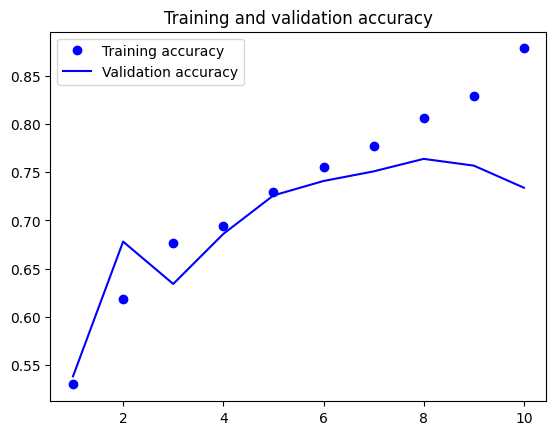

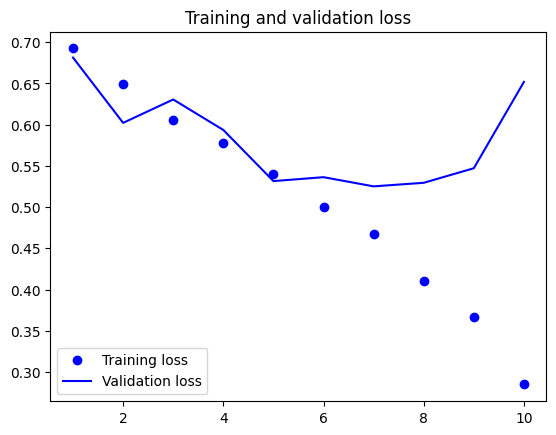

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 25s 782ms/step - loss: 0.5604 - accuracy: 0.7360
Test accuracy: 0.736


#Transferring pictures to test, validation, and training folders and intially considering 3000 for train, 500 for test and 500 for validation

In [ ]:
import os
import shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_small_3000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

# Define the ranges for each subset
subset_ranges = {
    "train": (0, 3000),
    "validation": (3000, 3500),
    "test": (3500, 4000)
}

# Generate the subsets
for subset_name, (start, end) in subset_ranges.items():
    make_subset(subset_name, start, end)


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input shape
input_shape = (180, 180, 3)
inputs = keras.Input(shape=input_shape)

# Data preprocessing: Rescale the input values to the range [0, 1]
x = layers.Rescaling(1./255)(inputs)

# Define the convolutional layers
conv_filters = [32, 64, 128, 256, 256]
for filters in conv_filters:
    x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

# Flatten the output for fully connected layers
x = layers.Flatten()(x)

# Define the output layer with sigmoid activation for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                      

**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

#Training = 3000; Validation = 500; Test = 500

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 6000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')


**Fitting the model using a `Dataset`**

In [ ]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/10
188/188 [==============================] - 523s 3s/step - loss: 0.2384 - val_loss: 0.2174
Epoch 2/10
188/188 [==============================] - 550s 3s/step - loss: 0.2136 - val_loss: 0.2062
Epoch 3/10
188/188 [==============================] - 509s 3s/step - loss: 0.1998 - val_loss: 0.2149
Epoch 4/10
188/188 [==============================] - 472s 3s/step - loss: 0.1861 - val_loss: 0.1861
Epoch 5/10
188/188 [==============================] - 485s 3s/step - loss: 0.1620 - val_loss: 0.1673
Epoch 6/10
188/188 [==============================] - 469s 2s/step - loss: 0.1401 - val_loss: 0.1548
Epoch 7/10
188/188 [==============================] - 485s 3s/step - loss: 0.1179 - val_loss: 0.1602
Epoch 8/10
188/188 [==============================] - 467s 2s/step - loss: 0.0944 - val_loss: 0.1444
Epoch 9/10
188/188 [==============================] - 467s 2s/step - loss: 0.0716 - val_loss: 0.1661
Epoch 10/10
188/188 [==============================] - 471s 3s/step - loss: 0.0532 - val_lo

# Evaluating the model on the test set

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

# **Using data augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Showing some randomly enhanced training pictures

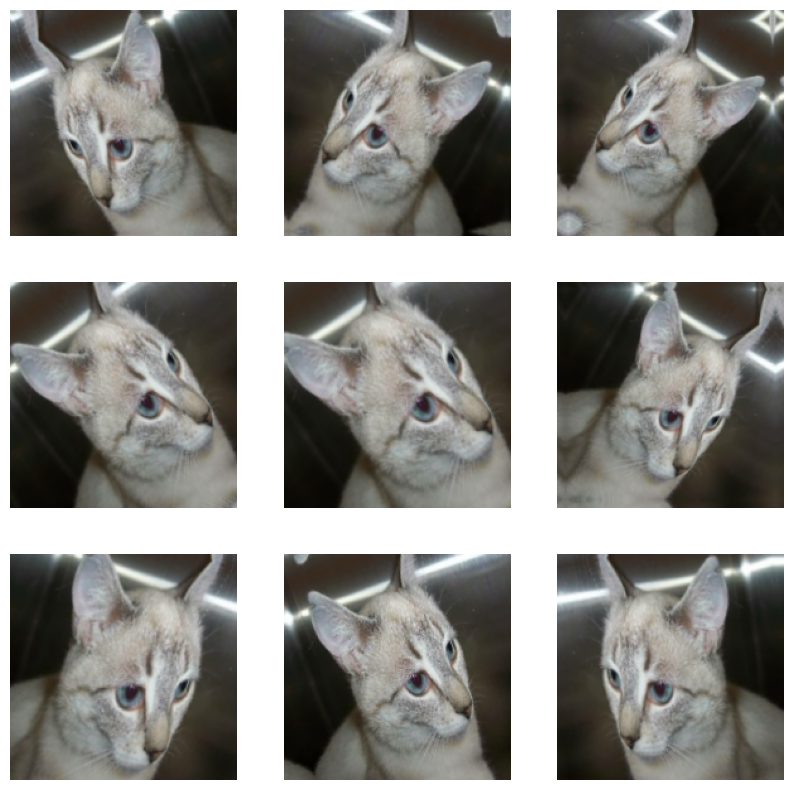

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# **Defining a new convnet that includes image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# **Training the regularized convnet**

In [ ]:
Have run with data augmentation for training set of 1000,2000 and 3000
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

# **Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 35s 1s/step - loss: 0.5944 - accuracy: 0.6840
Test accuracy: 0.684


# Using a pretrained model


In [16]:
import keras
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

# Feature extraction without data augmentation

In [18]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 2s 2s/step


#Defining and training the classifier

In [19]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.x",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 5s 61ms/step - loss: 14.0439 - accuracy: 0.9235 - val_loss: 4.2965 - val_accuracy: 0.9780
Epoch 2/10
63/63 [==============================] - 3s 46ms/step - loss: 1.8190 - accuracy: 0.9840 - val_loss: 7.5707 - val_accuracy: 0.9640
Epoch 3/10
63/63 [==============================] - 4s 61ms/step - loss: 0.8150 - accuracy: 0.9920 - val_loss: 4.6330 - val_accuracy: 0.9770
Epoch 4/10
63/63 [==============================] - 3s 46ms/step - loss: 1.0827 - accuracy: 0.9925 - val_loss: 6.2169 - val_accuracy: 0.9630
Epoch 5/10
63/63 [==============================] - 3s 44ms/step - loss: 1.2509 - accuracy: 0.9895 - val_loss: 6.3568 - val_accuracy: 0.9660
Epoch 6/10
63/63 [==============================] - 3s 44ms/step - loss: 0.4330 - accuracy: 0.9960 - val_loss: 5.9865 - val_accuracy: 0.9700
Epoch 7/10
63/63 [==============================] - 4s 62ms/step - loss: 0.3814 - accuracy: 0.9965 - val_loss: 6.1820 - val_accuracy: 0.9710
Epoch 8/10
6

# Graphical representation

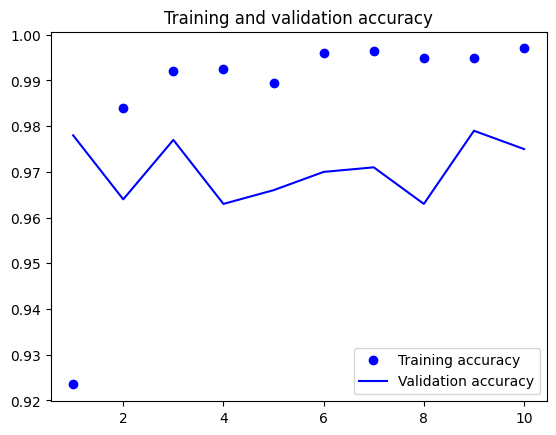

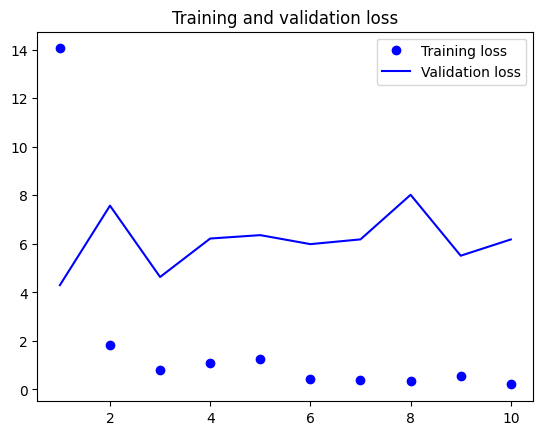

In [20]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [22]:
test_loss, test_accuracy = model.evaluate(test_features, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

32/32 [==============================] - 0s 10ms/step - loss: 7.3143 - accuracy: 0.9730
Test Loss: 7.314322471618652
Test Accuracy: 0.9729999899864197


# Changing optimizer to rmsprop

In [23]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.x",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 4s 49ms/step - loss: 15.1776 - accuracy: 0.9270 - val_loss: 4.7653 - val_accuracy: 0.9590
Epoch 2/10
63/63 [==============================] - 3s 46ms/step - loss: 4.0095 - accuracy: 0.9705 - val_loss: 4.2833 - val_accuracy: 0.9680
Epoch 3/10
63/63 [==============================] - 4s 59ms/step - loss: 1.8449 - accuracy: 0.9865 - val_loss: 4.0493 - val_accuracy: 0.9720
Epoch 4/10
63/63 [==============================] - 2s 37ms/step - loss: 0.4529 - accuracy: 0.9940 - val_loss: 5.5087 - val_accuracy: 0.9670
Epoch 5/10
63/63 [==============================] - 2s 37ms/step - loss: 1.3404 - accuracy: 0.9895 - val_loss: 4.9823 - val_accuracy: 0.9730
Epoch 6/10
63/63 [==============================] - 2s 37ms/step - loss: 0.7826 - accuracy: 0.9935 - val_loss: 7.6505 - val_accuracy: 0.9590
Epoch 7/10
63/63 [==============================] - 3s 48ms/step - loss: 1.0809 - accuracy: 0.9915 - val_loss: 3.7903 - val_accuracy: 0.9840
Epoch 8/10
6

In [24]:
test_loss, test_accuracy = model.evaluate(test_features, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

32/32 [==============================] - 1s 23ms/step - loss: 7.3946 - accuracy: 0.9660
Test Loss: 7.3945770263671875
Test Accuracy: 0.9660000205039978


# Feature extraction together with data augmentation

In [ ]:
import keras
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

# Printing the trainable weights list both before and after the freezer

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


# incorporating a classifier and a data augmentation stage into the convolutional base

In [ ]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/10
63/63 [==============================] - 734s 12s/step - loss: 5.1359 - accuracy: 0.9485 - val_loss: 5.5648 - val_accuracy: 0.9630
Epoch 2/10
63/63 [==============================] - 744s 12s/step - loss: 4.5718 - accuracy: 0.9595 - val_loss: 4.9573 - val_accuracy: 0.9670
Epoch 3/10
63/63 [==============================] - 712s 11s/step - loss: 3.7613 - accuracy: 0.9610 - val_loss: 3.0344 - val_accuracy: 0.9770
Epoch 4/10
63/63 [==============================] - 733s 12s/step - loss: 3.1795 - accuracy: 0.9720 - val_loss: 3.6324 - val_accuracy: 0.9750
Epoch 5/10
63/63 [==============================] - 733s 12s/step - loss: 3.5352 - accuracy: 0.9610 - val_loss: 3.3086 - val_accuracy: 0.9730
Epoch 6/10
63/63 [==============================] - 733s 12s/step - loss: 1.9264 - accuracy: 0.9755 - val_loss: 3.3562 - val_accuracy: 0.9740
Epoch 7/10
63/63 [==============================] - 734s 12s/step - loss: 1.7471 - accuracy: 0.9825 - val_loss: 4.0977 - val_accuracy: 0.9760
Epoch 

# Graphical representation

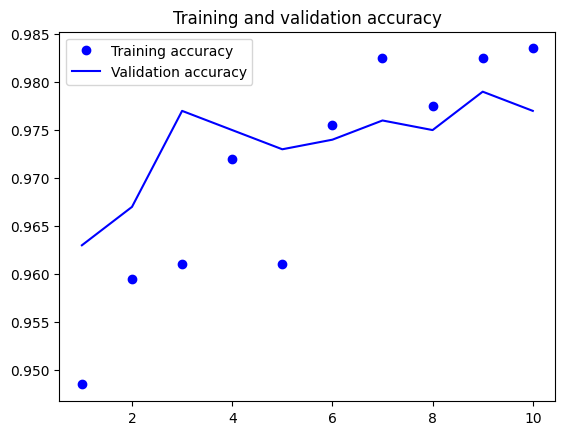

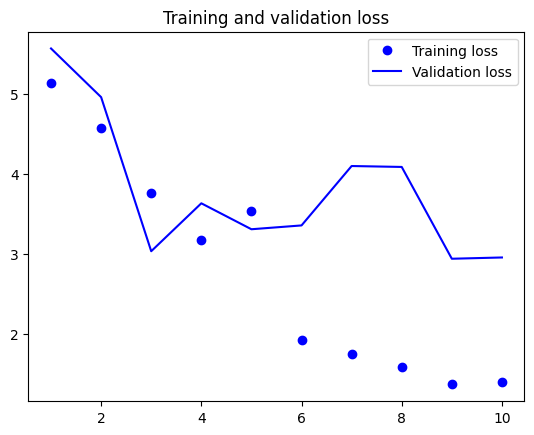

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Evaluating the model on the test set

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 238s 7s/step - loss: 3.4010 - accuracy: 0.9720
Test accuracy: 0.972


In [ ]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)


#Evaluating model on test set

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")